In [1]:
using PyPlot, Optim, Statistics, CSV

PyPlot.matplotlib.style.use("seaborn-pastel")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
rcParams["lines.linewidth"] = 3

pygui(false) # true if you want interactive plots to pop up

false

# optimizing a function in `Optim.jl`

e.g. yeast growth. put data `yeast.csv` in your present working directory `pwd()`.

In [2]:
pwd()

"/home/cokes/control_theory_demos/demos"

In [3]:
df = CSV.read("yeast.csv") # read in data
first(df, 10) # look at first ten rows

,time,yeast
,Float64,Float64
1,0.0,0.0681856
2,1.37607,0.0948776
3,5.69534,0.175096
4,7.82451,0.234266
5,13.1052,0.292971
6,15.0799,0.336679
7,16.7532,0.412016
8,19.5088,0.499882
9,24.8834,0.762797


unpack `DataFrame` into arrays (since you don't know how to use `DataFrame`s.

In [4]:
t = df[:, :time]

11-element Array{Float64,1}:
  0.0               
  1.3760668481362115
  5.695340582080408 
  7.824511301916132 
 13.105232091621414 
 15.07994806299439  
 16.75321800262156  
 19.50881622452532  
 24.883401281831848 
 28.612073485350475 
 31.567209804398757 

In [5]:
y = df[:, :yeast]

11-element Array{Float64,1}:
 0.06818555749741226
 0.09487763943629532
 0.1750957931407423 
 0.2342657336848174 
 0.29297064118142857
 0.3366786252165307 
 0.41201590393704757
 0.4998823443984025 
 0.7627970859779638 
 1.037178980851983  
 1.3322336154225518 

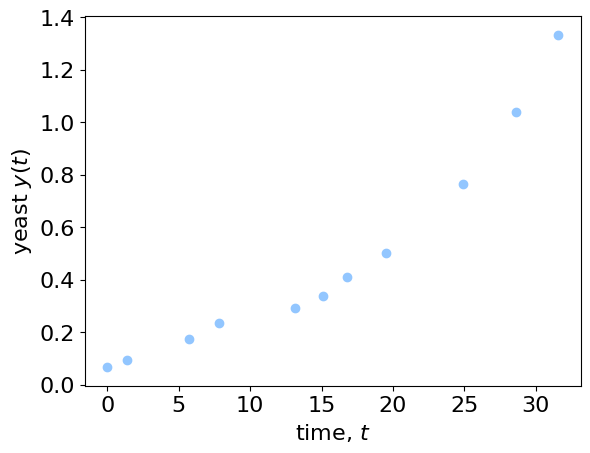

PyObject Text(34.0, 0.5, 'yeast $y(t)$')

In [6]:
figure()
scatter(t, y)
xlabel(L"time, $t$")
ylabel(L"yeast $y(t)$")

exponential growth model for yeast:

$$\frac{dy}{dt}=at$$

$\implies y(t)=y(t=0)e^{at}$.

In [8]:
y_model(t, a) = y[1] * exp(a * t)

y_model (generic function with 1 method)

**goal**: find $a$ from data.

cost function:

$$\displaystyle\sum_{n=1}^{11} [y_i - y(t=0)e^{at_i}]^2$$

where data point $i$ is the pair $(t_i, y_i)$.

In [11]:
function cost(a)
    c = 0.0
    for i = 1:length(t)
        residual_i = y[i] - y_model(t[i], a)
        c += residual_i ^ 2 # same as c = c + residual_i ^ 2
    end
    return c
end

cost (generic function with 1 method)

visualize the cost

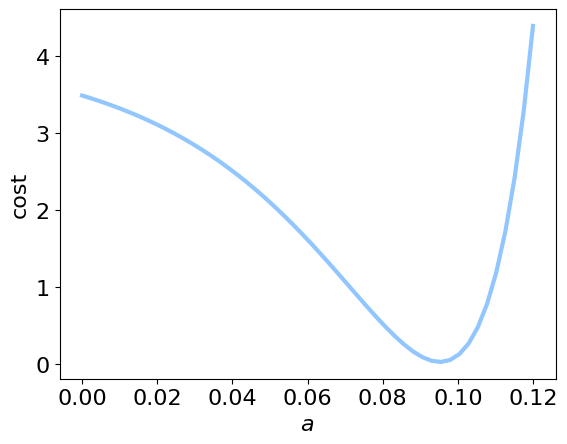

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fac68f65860>

In [12]:
as = range(0.0, 0.12, length=50)

figure()
xlabel(L"$a$")
ylabel("cost")
plot(as, cost.(as))

minimize the cost

In [13]:
opt_res = optimize(cost, 0.0, 0.16) # tell Optim.jl the optimum a is between 0 and 0.16

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 0.160000]
 * Minimizer: 9.523942e-02
 * Minimum: 3.035639e-02
 * Iterations: 14
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 15

In [14]:
a_opt = opt_res.minimizer

0.09523942185486281

visualize fit to data

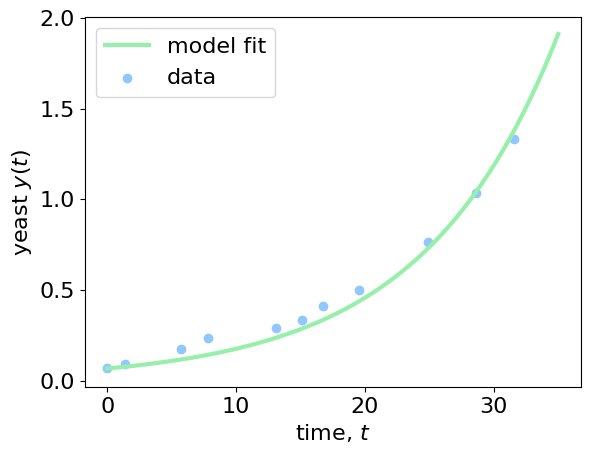

PyObject <matplotlib.legend.Legend object at 0x7fac671b2f60>

In [17]:
figure()
scatter(t, y, label="data")
xlabel(L"time, $t$")
ylabel(L"yeast $y(t)$")
t_plot = range(0.0, 35, length=100)
plot(t_plot, y_model.(t_plot, a_opt), label="model fit", color="C1")
legend()

## ambitous Beavers: multi-dimensional optimization via Nelder-Mead

consider Rosenbrock's banana function (see [Wikipedia](https://en.wikipedia.org/wiki/Rosenbrock_function)):

$$f(\mathbf{x})=f(x_1, x_2)=(a-x_1)^2+b(x_2-x_1^2)^2$$

In [18]:
a = 1.0
b = 0.2
f(x) = (a - x[1]) ^ 2 + b * (x[2] - x[1] ^ 2) ^ 2

f (generic function with 1 method)

In [19]:
function viz(f, x₀::Array{Float64, 1}, xₘ::Array{Float64, 1})
    x₁ = range(-2.0, 2.0, length=50)
    x₂ = range(-4.0, 4.0, length=60)

    y = zeros(length(x₂), length(x₁))
    for i = 1:length(x₂)
        for j = 1:length(x₁)
            y[i, j] = f([x₁[j], x₂[i]])
        end
    end
    
    figure()
    plot_surface(x₁, x₂, y, alpha=0.5, cmap="viridis")
    scatter3D([x₀[1]], [x₀[2]], [0.0], color="k")
    scatter3D([xₘ[1]], [xₘ[2]], [0.0], color="r")
    for x in [x₀, xₘ]
        plot3D([x[1], x[1]], [x[2], x[2]], [0.0, f(x)], color="gray")
    end
    xlabel(L"$x_1$")
    ylabel(L"$x_2$")
    zlabel(L"$f(x_1, x_2)$")
    zlim(zmin=0)
    tight_layout()
end

viz (generic function with 1 method)

In [20]:
x₀ = [-1.0, 0.0] # initial guess

opt_res = optimize(f, x₀, NelderMead())

pygui(true)

println("x that minimizes f(x): ", opt_res.minimizer)
println("min f(x): ", opt_res.minimum)

viz(f, x₀, opt_res.minimizer)

x that minimizes f(x): [1.0001999624681903, 1.000354374495811]
min f(x): 4.040068606528116e-8
